# Análisis exploratorio del humor textual

## Carga y exploración inicial

In [1]:
import pandas as pd
data = pd.read_csv("/content/dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


Se tienen 2 variables con 200 000 filas de datos. No hay valores nulos.
* **text** es columna de texto.
* **humor** es columna booleana (indica si el texto es humorístico o no).

## Limpieza de datos

In [ ]:
import pandas as pd
import re
import unicodedata

def normalizar_texto(texto):
  # Pasar a minúsculas.
  texto = texto.lower()
  # Eliminar tildes y caracteres especiales.
  texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
  # Eliminar puntuación.
  texto = re.sub(r'[^\w\s]', '', texto)
  # Eliminar espacios extras.
  texto = re.sub(r'\s+', ' ', texto).strip()
  return texto

data["normalized_text"] = data['text'].apply(normalizar_texto)
print(data["normalized_text"].head())

0     joe biden rules out 2020 bid guys im not running
1    watch darvish gave hitter whiplash with slow p...
2     what do you call a turtle without its shell dead
3        5 reasons the 2016 election feels so personal
4    pasco police shot mexican migrant from behind ...
Name: normalized_text, dtype: object


En el fragmento de código anterior se ha normalizado el texto, pasando a minúsculas, eliminando tildes y caracteres especiales, eliminando puntuación y espacios extras.

## Estadística descriptiva

In [ ]:
data["humor"].value_counts()

,count
humor,
False,100000
True,100000


Se observa que la mitad de los textos han sido etiquetados como humorísticos y la otra mitad como no humorísticos.

In [ ]:
data["length"] = data["normalized_text"].apply(len)
data_humor = data[data["humor"] == True]
data_no_humor = data[data["humor"] == False]
print("Longitud promedio de los textos humorísticos: ", round(data_humor["length"].mean(),1))
print("Longitud promedio de los textos no humorísticos: ", round(data_no_humor["length"].mean(),1))

Longitud promedio de los textos humorísticos:  67.0
Longitud promedio de los textos no humorísticos:  63.3


In [ ]:
from collections import Counter

# Unir todos los textos en uno solo.
texto_completo = ' '.join(data["normalized_text"])
# Separar en palabras.
palabras = texto_completo.split()
# Contar frecuencias.
frec_pal = Counter(palabras)
# Data Frame con palabras y frecuencias.
df_frec_pal = pd.DataFrame(frec_pal.items(), columns = ["Palabra", "Frecuencia"]).sort_values(by = "Frecuencia", ascending = False)
print("Palabras más comunes: ")
print(df_frec_pal.head(10))

Palabras más comunes: 
    Palabra  Frecuencia
30      the       83099
22        a       77244
99       to       54037
20      you       36230
70       in       33282
60       of       32975
168       i       29224
81      and       28001
18     what       26693
55       is       24955


Este tipo de palabras son las llamadas *stopwords* y son palabras de uso frecuente que no aportan mucho significado y que se ignoran en algunos procesos de análisis de texto, como conviene en nuestro caso. Además, nos interesa ver las palabras mas frecuentes por clase (humorístico y no humorístico).

In [ ]:
# Descargar stopwords (palabras vacías).
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd

# Stopwords en español.
stop_words = set(stopwords.words('english'))

# Función para contar palabras filtradas.
def get_word_freq(df, text_column='normalized_text'):
    words = ' '.join(df[text_column]).split()
    filtered = [w for w in words if w not in stop_words]
    return pd.DataFrame(Counter(filtered).items(), columns=["Palabra", "Frecuencia"])\
             .sort_values(by="Frecuencia", ascending=False)

# Aplicar a textos con y sin humor.
df_frec_pal_humor = get_word_freq(data[data["humor"] == True])
df_frec_pal_no_humor = get_word_freq(data[data["humor"] == False])

print("Palabras más comunes (humor)")
print(df_frec_pal_humor.head(10))
print("\n\nPalabras más comunes (no humor)")
print(df_frec_pal_no_humor.head(10))

Palabras más comunes (humor)
    Palabra  Frecuencia
0      call        8174
196    like        7530
220   whats        5563
85      get        5503
32       im        4984
271    dont        4602
151     say        4563
240     one        4047
677  people        3858
83     know        3142


Palabras más comunes (no humor)
    Palabra  Frecuencia
47    trump        5954
369  photos        5147
27      new        4921
104   video        3321
46   donald        2910
608      us        2803
88     says        2424
450     day        2319
277    make        1922
300  trumps        1922


## Visualizaciones

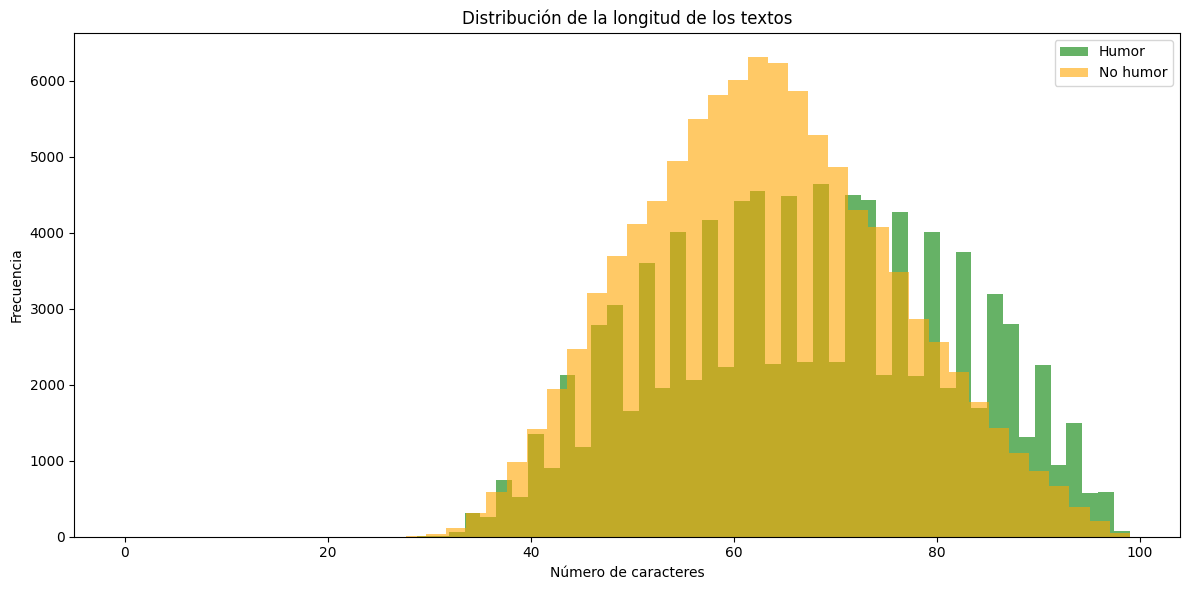

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Histograma para textos humorísticos.
plt.hist(data[data['humor'] == True]['length'], bins=50, alpha=0.6, label='Humor', color='green')

# Histograma para textos no humorísticos.
plt.hist(data[data['humor'] == False]['length'], bins=50, alpha=0.6, label='No humor', color='orange')

plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

Las figuras anteriores son gráficas de la distribución de la longitud de los textos. Sus distribuciones se asemejan a una normal, pero con una ligera asimetría. En general, se observa que los textos humorísticos tienden a ser un poco más largos que los no humorísticos, además de que tienen una mayor varianza.

In [ ]:
pip install wordcloud

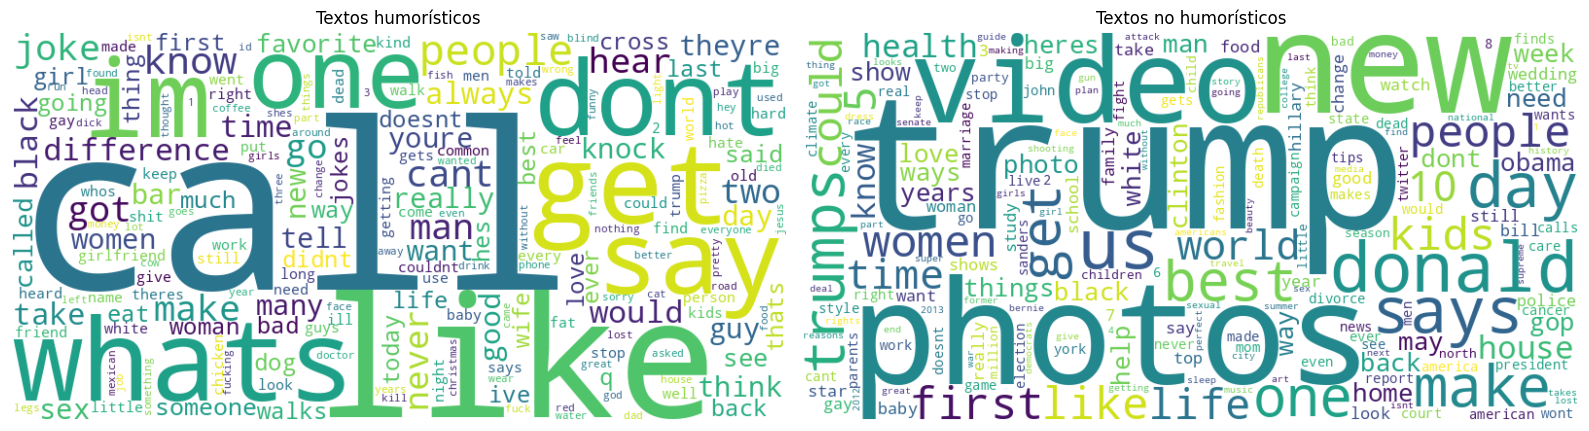

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear nubes de palabras desde diccionarios de frecuencia.
wordcloud_humor = WordCloud(width=800, height=400, background_color='white')\
    .generate_from_frequencies(dict(zip(df_frec_pal_humor['Palabra'], df_frec_pal_humor['Frecuencia'])))

wordcloud_no_humor = WordCloud(width=800, height=400, background_color='white')\
    .generate_from_frequencies(dict(zip(df_frec_pal_no_humor['Palabra'], df_frec_pal_no_humor['Frecuencia'])))

# Mostrar las nubes de palabras.
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_humor, interpolation='bilinear')
plt.axis('off')
plt.title("Textos humorísticos")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_no_humor, interpolation='bilinear')
plt.axis('off')
plt.title("Textos no humorísticos")

plt.tight_layout()
plt.show()

En los diagrmas anteriores, las palabras con mayor tamaño son las que tienen mayores frecuencias de aparición en los textos humorísticos y no humorísticos, respectivamente. Pareciera que las palabras más frecuentes en los textos humorísticos pertenecen a un lenguaje informal, mientras que los no humorísticos a un lenguaje formal.

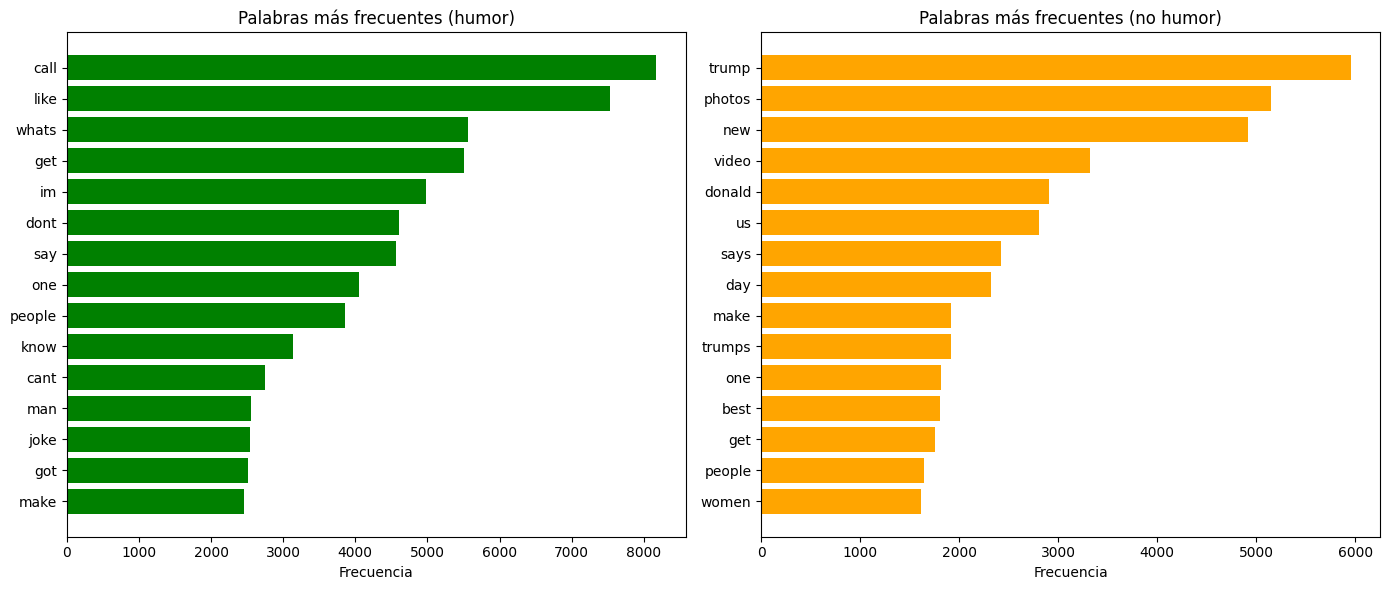

In [ ]:
# Número de palabras a mostrar
top_n = 15

plt.figure(figsize=(14, 6))

# Gráfico de barras: Humor
plt.subplot(1, 2, 1)
plt.barh(df_frec_pal_humor.head(top_n)['Palabra'][::-1],
         df_frec_pal_humor.head(top_n)['Frecuencia'][::-1],
         color='green')
plt.title("Palabras más frecuentes (humor)")
plt.xlabel("Frecuencia")

# Gráfico de barras: No humor
plt.subplot(1, 2, 2)
plt.barh(df_frec_pal_no_humor.head(top_n)['Palabra'][::-1],
         df_frec_pal_no_humor.head(top_n)['Frecuencia'][::-1],
         color='orange')
plt.title("Palabras más frecuentes (no humor)")
plt.xlabel("Frecuencia")

plt.tight_layout()
plt.show()


Las gráficas anteriores muestran que las palabras frecuentes en los textos humorísticos son más frecuentes que las palabras frecuentes en los textos no humorísticos, lo cual da indicio de la existencia de una estructura típica y repetida en los textos humorísticos.

In [ ]:
data.to_csv("dataset (b).csv", index=False)